<img src="../images/cmip6-cookbook-thumbnail.png" width=250 alt="CMIP6 image"></img>

# Precipitation Frequency Analysis

---

## Overview

This notebook shows an advanced analysis case. The calculation was inspired by Angie Pendergrass’s work on precipitation statistics, as described in the following websites / papers:

- [https://journals.ametsoc.org/doi/full/10.1175/JCLI-D-16-0684.1](https://journals.ametsoc.org/doi/full/10.1175/JCLI-D-16-0684.1)
- [https://climatedataguide.ucar.edu/climate-data/gpcp-daily-global-precipitation-climatology-project](https://climatedataguide.ucar.edu/climate-data/gpcp-daily-global-precipitation-climatology-project)

We use [`xhistogram`](https://xhistogram.readthedocs.io/en/latest/) to calculate the distribution of precipitation intensity and its changes in a warming climate.

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Xarray](https://foundations.projectpythia.org/core/xarray/xarray-intro.html) | Necessary | |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Helpful | Familiarity with metadata structure |
| Dask | Helpful | |

- **Time to learn**: 5 minutes

---

## Imports

In [1]:
import os
import sys
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import fsspec
from tqdm.autonotebook import tqdm
from xhistogram.xarray import histogram
from dask_gateway import Gateway
from dask.distributed import Client

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6

/tmp/ipykernel_953/106887996.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Compute Cluster

Here we use a dask cluster to parallelize our analysis.

In [2]:
platform = sys.platform

if (platform == 'win32'):
    import multiprocessing.popen_spawn_win32
else:
    import multiprocessing.popen_spawn_posix

Initiate the Dask client:

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 122.83 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35405,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 122.83 GiB
Comm: tcp://127.0.0.1:39197,Total threads: 4
Dashboard: http://127.0.0.1:36931/status,Memory: 15.35 GiB
Nanny: tcp://127.0.0.1:40119,


## Load Data Catalog

In [4]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ps,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rsds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlus,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,rlds,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,psl,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


In [5]:
df_3hr_pr = df[(df.table_id == '3hr') & (df.variable_id == 'pr')]
len(df_3hr_pr)

78

In [6]:
run_counts = df_3hr_pr.groupby(['source_id', 'experiment_id'])['zstore'].count()
run_counts

source_id         experiment_id     
BCC-CSM2-MR       historical             1
                  ssp126                 1
                  ssp245                 1
                  ssp370                 1
                  ssp585                 1
CNRM-CM6-1        highresSST-present     1
                  historical             3
                  ssp126                 1
                  ssp245                 1
                  ssp370                 1
                  ssp585                 1
CNRM-CM6-1-HR     highresSST-present     1
CNRM-ESM2-1       historical             1
                  ssp126                 1
                  ssp245                 1
                  ssp370                 1
                  ssp585                 1
GFDL-CM4          1pctCO2                2
                  abrupt-4xCO2           2
                  amip                   2
                  historical             2
                  piControl              2
GFDL-CM4C192     

In [7]:
source_ids = []
experiment_ids = ['historical', 'ssp585']
for name, group in df_3hr_pr.groupby('source_id'):
    if all([expt in group.experiment_id.values
            for expt in experiment_ids]):
        source_ids.append(name)
source_ids

# Use only one model. Otherwise it takes too long to run on GitHub.
source_ids = ['BCC-CSM2-MR']

In [8]:
def load_pr_data(source_id, expt_id):
    """
    Load 3hr precip data for given source and expt ids
    """
    uri = df_3hr_pr[(df_3hr_pr.source_id == source_id) &
                         (df_3hr_pr.experiment_id == expt_id)].zstore.values[0]

    ds = xr.open_zarr(fsspec.get_mapper(uri), consolidated=True)
    return ds

In [9]:
def precip_hist(ds, nbins=100, pr_log_min=-3, pr_log_max=2):
    """
    Calculate precipitation histogram for a single model.
    Lazy.
    """
    assert ds.pr.units == 'kg m-2 s-1'

    # mm/day
    bins_mm_day = np.hstack([[0], np.logspace(pr_log_min, pr_log_max, nbins)])
    bins_kg_m2s = bins_mm_day / (24*60*60)

    pr_hist = histogram(ds.pr, bins=[bins_kg_m2s], dim=['lon']).mean(dim='time')

    log_bin_spacing = np.diff(np.log(bins_kg_m2s[1:3])).item()
    pr_hist_norm = 100 * pr_hist / ds.dims['lon'] / log_bin_spacing
    pr_hist_norm.attrs.update({'long_name': 'zonal mean rain frequency',
                               'units': '%/Δln(r)'})
    return pr_hist_norm

def precip_hist_for_expts(dsets, experiment_ids):
    """
    Calculate histogram for a suite of experiments.
    Eager.
    """
    # actual data loading and computations happen in this next line
    pr_hists = [precip_hist(ds).load()
            for ds in [ds_hist, ds_ssp]]
    pr_hist = xr.concat(pr_hists, dim=xr.Variable('experiment_id', experiment_ids))
    return pr_hist

In [10]:
results = {}
for source_id in tqdm(source_ids):
    # get a 20 year period
    ds_hist = load_pr_data(source_id, 'historical').sel(time=slice('1980', '2000'))
    ds_ssp = load_pr_data(source_id, 'ssp585').sel(time=slice('2080', '2100'))
    pr_hist = precip_hist_for_expts([ds_hist, ds_ssp], experiment_ids)
    results[source_id] = pr_hist

  0%|          | 0/1 [00:00<?, ?it/s]

In [11]:
def plot_precip_changes(pr_hist, vmax=5):
    """
    Visualize the output
    """
    pr_hist_diff = (pr_hist.sel(experiment_id='ssp585') -
                    pr_hist.sel(experiment_id='historical'))
    pr_hist.sel(experiment_id='historical')[:, 1:].plot.contour(xscale='log', colors='0.5', levels=21)
    pr_hist_diff[:, 1:].plot.contourf(xscale='log', vmax=vmax, levels=21)

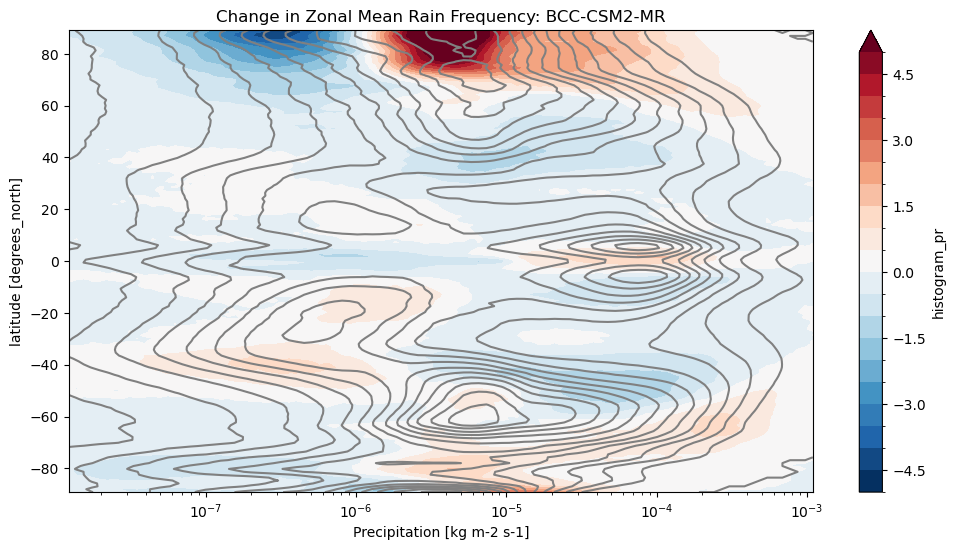

In [12]:
title = 'Change in Zonal Mean Rain Frequency'
for source_id, pr_hist in results.items():
    plt.figure()
    plot_precip_changes(pr_hist)
    plt.title(f'{title}: {source_id}')

We're at the end of the notebook, so let's shutdown our Dask cluster.

In [13]:
client.shutdown()

---

## Summary
In this notebook, we used CMIP6 data to compare precipitation intensity in the SSP585 scenario to historical runs.

### What's next?
More examples of using CMIP6 data.

## Resources and references
- [Original notebook in the Pangeo Gallery](http://gallery.pangeo.io/repos/pangeo-gallery/cmip6/precip_frequency_change.html) by Henri Drake and [Ryan Abernathey](https://ocean-transport.github.io/)